In [1]:
import numpy as np
import pandas as pd

# Входные данные

In [2]:
shell = 0 # рассчитываем оболочку или нет
R = np.inf # радиус оболочки (np.inf - прямая пластина)
plate = 1
plate1 = 0

In [3]:
E = 7e10  # модуль Юнга
ro = 2700  # плотоность алюминия
nu = 0.33  # коэффицент Пуассона
G = E / (2 * (1 + nu))  # модуль сдвига
L = 1.5  # L1  
W = 1.5   # L2
h = 0.002   # тодщина пластины
D = (E * h ** 3) / (12 * (1 - nu ** 2))  # жесткость из уравнения колебания
N_end = 10  # расчтеные моды
M_end = 10
q1_end = 2   # число шпангаутов
q2_end = 9   # число стрингеров
h_sh = 0.1 # высота шпангоута
h_st = 0.02 # высота стрингера
b_sh_st = 0.002 # толщина сечения стрингера и шпангоута
S = N_end * M_end

In [4]:
if shell == 0 and R < 10000:
    plate1 = 1
    plate = 0
elif shell == 1:
    W = 2 * np.pi * R
    plate = 0
    plate1 = 0

# Расчет характеристик стрингеров и шпангоутов

In [5]:
S_sh = h_sh * b_sh_st  # профиль шпангоута
S_st = h_st * b_sh_st # профиль стрингера
I_sh = b_sh_st * (h_sh ** 3) / 12  # моменты инерции относительно оси y (толщина сечения)
I_st = b_sh_st * (h_st ** 3) / 12
# моменты кручения
Ik_sh = ((b_sh_st ** 3) * h_sh / 3) * (1 - 0.63 * (b_sh_st / h_sh) + 0.052 * (b_sh_st / h_sh) ** 5)
Ik_st = ((b_sh_st ** 3) * h_st / 3) * (1 - 0.63 * (b_sh_st / h_st) + 0.052 * (b_sh_st / h_st) ** 5)
# полярные моменты
Iro_sh = 0.5 * (b_sh_st * h_sh) * (h_sh ** 2 + b_sh_st ** 2)
Iro_st = 0.5 * (b_sh_st * h_st) * (h_st ** 2 + b_sh_st ** 2)
# погонные плотности шпангаутов и стрингеров (на единицу длины пластины)
ma_sh = ro * S_sh
ma_st = ro * S_st

In [6]:
# геометрия стрингеров и шпангоутов
b_pan_sh = L / (q1_end + 1) # пролет шпангаута
b_pan_st = W / (q2_end + 1) # пролет стрингера
S_pan_sh = b_pan_sh * h
S_pan_st = b_pan_st * h
V_sh = S_pan_sh * (h / 2 + h_sh / 2) / (S_pan_sh + S_sh)
V_st = S_pan_st * (h / 2 + h_st / 2) / (S_pan_st + S_st)

In [7]:
# координаты стрингеров и шпангоутов
x1 = np.arange(1, q1_end + 1) * b_pan_sh
x2 = np.arange(1, q2_end + 1) * b_pan_st

# Задаем пластину

In [8]:
# функции для вычисления ki, kj
def ku1(i):
    return (np.pi * i) / L
def ku2(j):
    return plate * (np.pi * j) / W + plate1 * (np.pi * j) / W + shell * j / R

In [9]:
# задаем матрицу оператора d^4/dx^4
Z0_eig = np.zeros((S, S))
for i in range(1, M_end + 1):
    for j in range(1 ,N_end + 1):
        k = (i - 1) * N_end + j
        ku = ku1(i) ** 4 + 2 * (ku1(i) * ku2(j)) ** 2 + ku2(j) ** 4
        Z0_eig[k-1][k-1] = D * ku + (plate1 * E * h * ku1(i) ** 4) / (ku * R ** 2) +(shell * E * h * ku1(i) ** 4) / (ku * R ** 2)

In [10]:
# задаем массовую матрицу
Z0_eig_m = np.diag([ro * h] * S)

In [11]:
# матрицы интегралов
V1 = np.diag([L / 2] * M_end)
V2 = np.diag([W / 2] * N_end)

# Матрицы для шпангоутов

In [12]:
sh10 = np.zeros((S, S))
sh20 = np.zeros((S, S))
for m1 in range(1, M_end + 1):
    for n1 in range(1, N_end + 1):
        for m2 in range(1, M_end + 1):
            for n2 in range(1, N_end + 1):
                j1 = (m1 - 1) * N_end + n1
                j2 = (m2 - 1) * N_end + n2
                Sum_r10_1, Sum_r20_1, Sum_r10_2, Sum_r20_2 = [0] * 4
                sh10_0 = E * (I_sh + S_sh * V_sh ** 2) * ku2(n1) ** 4
                sh20_0 = G * Ik_sh * (ku1(m1) * ku2(n1)) ** 2
                for q1 in x1:
                    # упругая матрица
                    Sum_r10_1 += (4 / (L * W)) * sh10_0 * np.sin(ku1(m1) * q1) * np.sin(ku1(m2) * q1) * V2[n1-1][n2-1]
                    Sum_r10_2 += (4 / (L * W)) * sh20_0 * np.sin(ku1(m1) * q1) * np.sin(ku1(m2) * q1) * V2[n1-1][n2-1]
                    # массовая матрица
                    Sum_r20_1 += (4 / (L * W)) * ma_sh * np.sin(ku1(m1) * q1) * np.sin(ku1(m2) * q1) * V2[n1-1][n2-1]
                    Sum_r20_2 += (4 / (L * W)) * ro * Iro_sh * (ku1(m1) ** 2) * np.sin(ku1(m1) * q1) * np.sin(ku1(m2) * q1) * V2[n1-1][n2-1]
                    
                sh10[j1-1][j2-1] = Sum_r10_1 + Sum_r10_2  # упругая
                sh20[j1-1][j2-1] = Sum_r20_1 + Sum_r20_2  # массовая

# Матрицы для стрингеров

In [13]:
st10 = np.zeros((S, S))
st20 = np.zeros((S, S))
for m1 in range(1, M_end + 1):
    for m2 in range(1, M_end + 1):
        for n1 in range(1, N_end + 1):
            for n2 in range(1, N_end + 1):
                j1 = (m1 - 1) * N_end + n1
                j2 = (m2 - 1) * N_end + n2
                Sum_r10_1, Sum_r20_1, Sum_r10_2, Sum_r20_2 = [0] * 4
                st10_0 = E * (I_st + S_st * V_st ** 2) * ku1(m1) ** 4
                st20_0 = G * Ik_st * (ku1(m1) * ku2(n1)) ** 2
                for q2 in x2:
                    # упругая матрица
                    slag1 = plate * np.sin(ku2(n1) * q2) * np.sin(ku2(n2) * q2) + shell * np.cos(ku2(n1) * q2) * np.cos(ku2(n2) * q2)
                    Sum_r10_1 += (4 / (L * W)) * st10_0 * V1[m1-1][m2-1] * slag1
                    slag2 = plate * np.cos(ku2(n1) * q2) * np.cos(ku2(n2) * q2) + shell * np.sin(ku2(n1) * q2) * np.sin(ku2(n2) * q2)
                    Sum_r10_2 += (4 / (L * W)) * st20_0 * ku2(n1) * ku2(n2) * V1[m1-1][m2-1] * slag2
                    # массовая матрица
                    Sum_r20_1 += (4 / (L * W)) * ma_st * V1[m1-1][m2-1] * slag1
                    Sum_r20_2 += (4 / (L * W)) * ro * Iro_st * V1[m1-1][m2-1] * slag2
                    
                st10[j1-1][j2-1] = Sum_r10_1 + Sum_r10_2  # упругая
                st20[j1-1][j2-1] = Sum_r20_1 + Sum_r20_2  # массовая

In [14]:
# упругая суммарная
Z0_eig_1 = Z0_eig + sh10 + st10
# массовая суммарная
Z0_eig_2 = Z0_eig_m + sh20 + st20

In [15]:
# финальная матрица
Z0_eig_final = np.linalg.inv(Z0_eig_2).T @ Z0_eig_1

In [16]:
# считаем собственные частоты
A, B = np.linalg.eig(Z0_eig_final)
eig_f = np.sqrt(np.sort(A)).reshape(N_end, M_end)
pd.DataFrame(eig_f / (np.pi * 2))

,0,1,2,3,4,5,6,7,8,9
0,70.501973,85.027158,125.644161,127.625048,134.228512,149.859076,153.747650,166.575755,179.023565,181.184304
1,199.969748,207.730664,212.446621,223.205843,235.443282,249.264777,251.279926,274.927683,282.747706,306.846549
2,312.376960,317.137410,357.816029,366.888516,380.487765,385.747008,426.046026,439.645030,445.642027,468.342752
3,501.456079,503.128454,508.881538,523.495591,527.852988,554.631024,566.628378,593.948433,608.344630,616.017452
4,625.958753,642.251061,654.718612,678.122594,690.951178,716.096653,750.637902,758.242138,767.696212,786.201763
5,788.762386,801.045607,805.803450,807.642251,869.132835,872.241789,877.112038,948.545380,950.182605,985.994207
6,989.940101,1015.900433,1127.844881,1128.105413,1129.402726,1135.022202,1149.048450,1180.937365,1236.755501,1248.030138
7,1249.484793,1254.984182,1267.755558,1298.478387,1329.528189,1351.979656,1442.135473,1463.427978,1534.168602,1572.736504
8,1592.160225,1608.346682,1618.455761,1644.539108,1665.343266,1752.304321,2293.951886,2366.520960,2484.677948,2492.314459
9,3564.351773,3571.902901,4843.625714,4852.219689,6321.390474,6331.627914,7997.128183,8009.452329,10141.223277,10218.921489


In [17]:
idx = A.argsort()   
A = A[idx]
B = B[:,idx]

# Рисуем решение

In [18]:
x = np.linspace(0, L, 1000)
y = np.linspace(0, W, 1000)
xx, yy = np.meshgrid(x, y)

In [32]:
mode = 2
w = np.sqrt(A[mode - 1]) / (np.pi * 2)

In [33]:
b = B[:, mode-1] # eigen vector

In [34]:
s = lambda i, j: (i - 1) * N_end + j - 1
zz1 = plate * np.array([[b[s(i, j)] * np.sin(ku1(i) * xx) * np.sin(ku2(j) * yy) for i in range(1, M_end + 1)] for j in range(1, N_end + 1)])
zz2 = shell * np.array([[b[s(i, j)] * np.sin(ku1(i) * xx) * np.cos(j * yy / R) for i in range(1, M_end + 1)] for j in range(1, N_end + 1)])

zz = zz1 + zz2

In [35]:
zz = np.sum(zz, (0, 1))

<IPython.core.display.Javascript object>


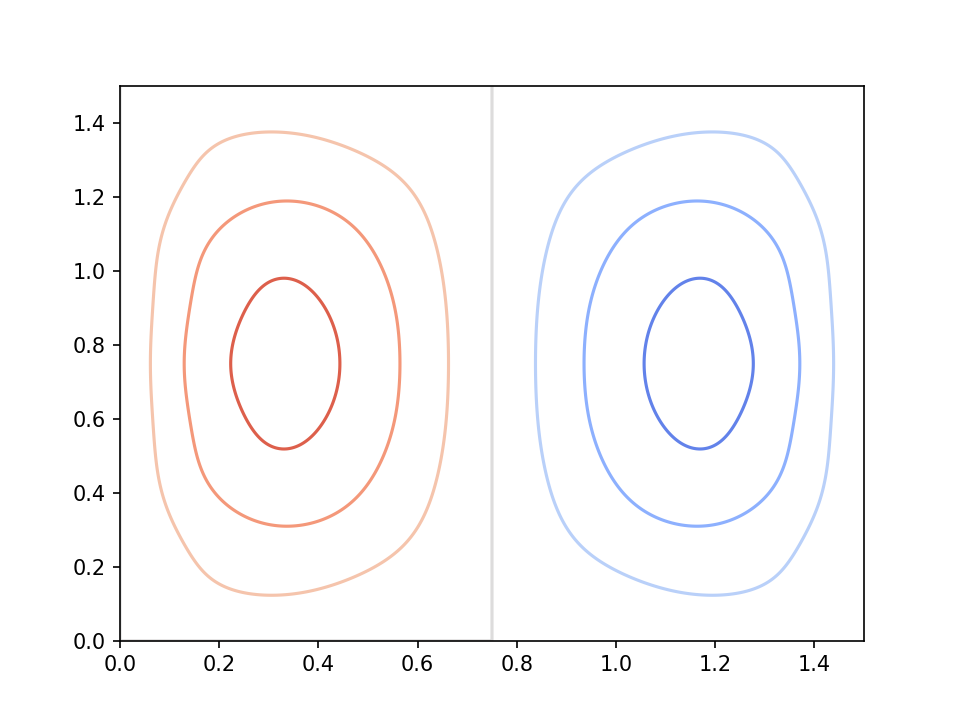

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook
# Рисуем моду
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(xx, yy, zz * (-1), cmap=cm.coolwarm)

In [36]:
# visualisation
fps = 10 # frame per sec
frn = 50 # frame number of the animation

In [37]:
t = np.linspace(0, 4 * np.pi / w11, frn)
z_arr = np.array([zz * np.cos(w11 * i + np.pi / 2) for i in t])

<IPython.core.display.Javascript object>


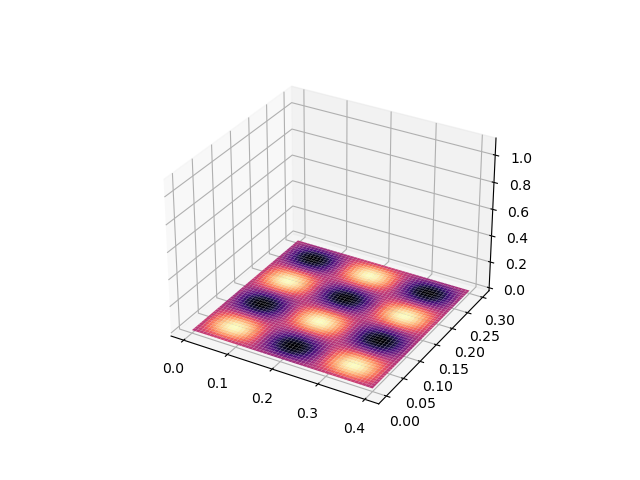

In [38]:
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(xx, yy, zarray[frame_number], cmap="magma")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(xx, yy, z_arr[0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,1.1)
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(z_arr, plot), interval=1000/fps)

In [39]:
fn = '3x4mode'
ani.save(fn+'.gif',writer='imagemagick',fps=fps)